# Simple Exploration Notebook - Zillow Prize
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize

이 노트에서, 우리는 질로우 경품 경진대회에서 주어진 데이터를 살펴보도록 하겠습니다. 데이터를 자세히 살펴보기 전 업체에 대해 자세히 알아보겠습니다.

__Zillow:__

질로우는 2006년에 설립된 온라인 부동산 데이터베이스 회사입니다.

__Zestimate:__

"Zestimate"는 각 속성에 대한 수백 개의 데이터 포인트를 분석하는 750만 개의 통꼐 및 기계 학습 모델을 기반으로 추정된 집 값입니다. 또한 중앙 오차 한계를 지속적으로 개선했습니다.(14퍼센트에서 현재 5퍼센트)

__목표:__

Zesimate 추정 잔차 오류를 개선하기 위한 모델 구축

먼저 필요한 모듈을 가져오겠습니다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

먼저 훈련 파일을 살펴보겠습니다.

In [3]:
train_df = pd.read_csv('./input/train_2016_v2.csv', parse_dates=['transactiondate'])
train_df.shape

(90275, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


### __Logerror:__
타겟 변수는 logerror 영역입니다. 이 영역에 대해 먼저 분석해보겠습니다.

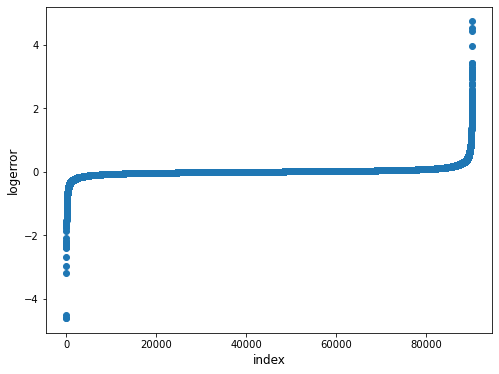

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

양쪽 끝의 이상치를 제거한 후 히스토그램을 그려보겠습니다.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


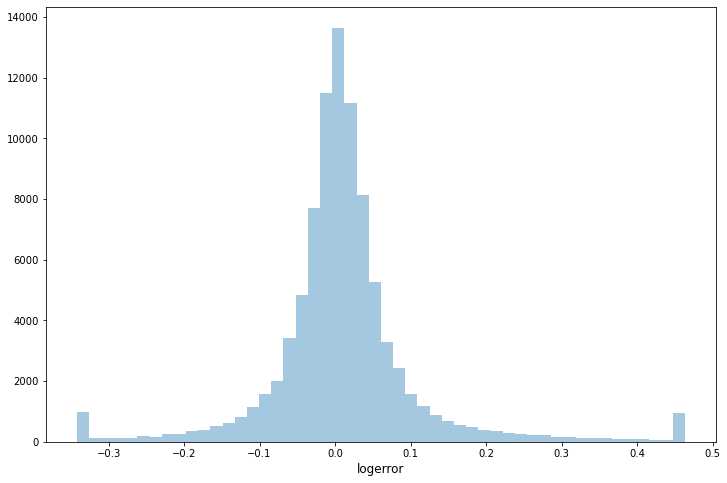

In [7]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'][train_df['logerror']>ulimit] = ulimit
train_df['logerror'][train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12, 8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

log error는 정규 분포처럼 보입니다.

### Transaction Date:

데이터를 살펴보겠습니다. 먼저 각 월별로 처리를 해보겠습니다.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


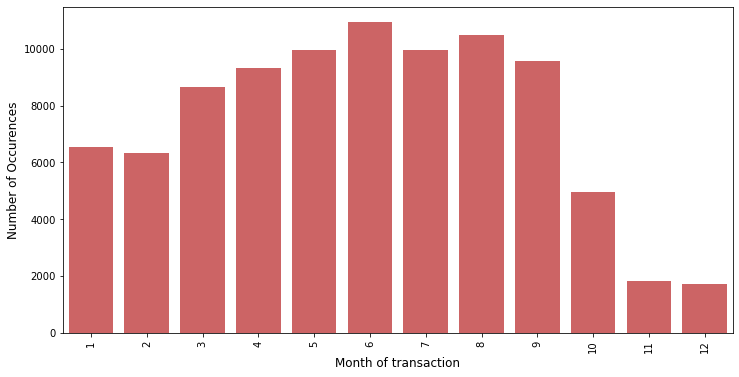

In [8]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurences', fontsize=12)
plt.show()

훈련 데이터는 2016년 10월 15일 이전의 모든 트랜젝션과 이후의 일부 트랜잭션을 포함합니다.

그래서 지난 3개월 동안 짧은 막대가 있습니다.

### parcel id:

In [9]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

대부분의 parcel id가 한번만 나타납니다.

### Properties 2016
properties_2016 파일을 살펴보겠습니다.

In [13]:
prop_df = pd.read_csv('./input/properties_2016.csv')
prop_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2985217, 58)

In [ ]:
prop_df.head() 

NaN값이 매우 많습니다. 이들에 대해 먼저 살펴보겠습니다

In [ ]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']]